In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

objc[51403]: Class CaptureDelegate is implemented in both /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x13cdc8860) and /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x332ece480). One of the two will be used. Which one is undefined.
objc[51403]: Class CVWindow is implemented in both /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x13cb30a68) and /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x332ece4d0). One of the two will be used. Which one is undefined.
objc[51403]: Class CVView is implemented in both /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x13cb30a90) and /Users/jainilpatel/PycharmPr

### 1. Set up important landmarks and functions

#### Generate Data Frame

According to my research *the correct form* for a squat is analyzed through the position of:
- Back
- Hip
- Legs

Therefore, there will be *9 keypoints* which will be extract from mediapipe in order to train or detect a correct form of a squat:
- "NOSE",
- "LEFT_SHOULDER",
- "RIGHT_SHOULDER",
- "LEFT_HIP",
- "RIGHT_HIP",
- "LEFT_KNEE",
- "RIGHT_KNEE",
- "LEFT_ANKLE",
- "RIGHT_ANKLE"

The data frame will be saved in a .csv file.

A data frame will contains a "Label" columns which represent the label of a data point.

There are another 9 x 4 columns represent 9 features of a human pose that are important for a squat.
In that each landmark's info will be flatten

According to the [Mediapipe documentation](https://google.github.io/mediapipe/solutions/pose#python-solution-api),
Each landmark consists of the following:
- x and y: Landmark coordinates normalized to [0.0, 1.0] by the image width and height respectively.
- z: Represents the landmark depth with the depth at the midpoint of hips being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of z uses roughly the same scale as x.
- visibility: A value in [0.0, 1.0] indicating the likelihood of the landmark being visible (present and not occluded) in the image.

In [2]:
# Determine important landmarks for squat
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

# Generate all columns of the data frame

landmarks = ["label"] # Label column

for lm in IMPORTANT_LMS:
    landmarks += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [3]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)
    

def init_csv(dataset_path: str):
    '''
    Create a blank csv file with just columns
    '''

    # Write all the columns to a file
    with open(dataset_path, mode="w", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(landmarks)

        
def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
    '''
    Export Labeled Data from detected landmark to csv
    '''
    landmarks = results.pose_landmarks.landmark
    keypoints = []

    try:
        # Extract coordinate of important landmarks
        for lm in IMPORTANT_LMS:
            keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
            keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
        keypoints = list(np.array(keypoints).flatten())

        # Insert action as the label (first column)
        keypoints.insert(0, action)

        # Append new row to .csv file
        with open(dataset_path, mode="a", newline="") as f:
            csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
        

    except Exception as e:
        print(e)
        pass


def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)


def describe_dataset(dataset_path: str):
    ''''''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {duplicate.sum(axis=1)}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

### 2. Extract data for train set

In [4]:
DATASET_PATH = "./train.csv"
VIDEO_PATH = "../data/squat/squat_posture.mp4"
VIDEO_PATH = "../../demo/squat_demo.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)
up_save_count = 0
down_save_count = 0

# init_csv(DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break
        
        # Reduce size of a frame
        image = rescale_frame(image, 60)
        image = cv2.flip(image, 1)

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"UP saved: {up_save_count}", (50, 150), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f"DOWN saved: {down_save_count}", (50, 200), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow("CV2", image)

         # Pressed key for action
        k = cv2.waitKey(1) & 0xFF

        if k == ord('d'): 
            export_landmark_to_csv(DATASET_PATH, results, "down")
            down_save_count += 1
        elif k == ord("u"):
            export_landmark_to_csv(DATASET_PATH, results, "up")
            up_save_count += 1
        # Press q to stop
        elif k == ord("q"):
            break
        else: continue

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)
        

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
df = describe_dataset(DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 4160 
Number of columns: 37

Labels: 
down    2127
up      2033
Name: label, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: float64)


### 3. Extract data for test set 

In [6]:
TEST_DATASET_PATH = "./test.csv"
VIDEO_PATH = "../data/squat/squat_test_4.mp4"
VIDEO_PATH = "../../demo/squat_demo.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)
up_save_count = 0
down_save_count = 0

# init_csv(TEST_DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break
            
        # Reduce size of a frame
        image = rescale_frame(image, 60)
        # image = cv2.flip(image, 1)

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"UP saved: {up_save_count}", (50, 150), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f"DOWN saved: {down_save_count}", (50, 200), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow("CV2", image)

         # Pressed key for action
        k = cv2.waitKey(1) & 0xFF

        if k == ord('d'): 
            export_landmark_to_csv(TEST_DATASET_PATH, results, "down")
            down_save_count += 1
        elif k == ord("u"):
            export_landmark_to_csv(TEST_DATASET_PATH, results, "up")
            up_save_count += 1
        # Press q to stop
        elif k == ord("q"):
            break
        else: continue

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)
        

### 4. Train custom model using Scikit Learn

#### 4.1 Read and describe data

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 4160 
Number of columns: 37

Labels: 
down    2127
up      2033
Name: label, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: float64)


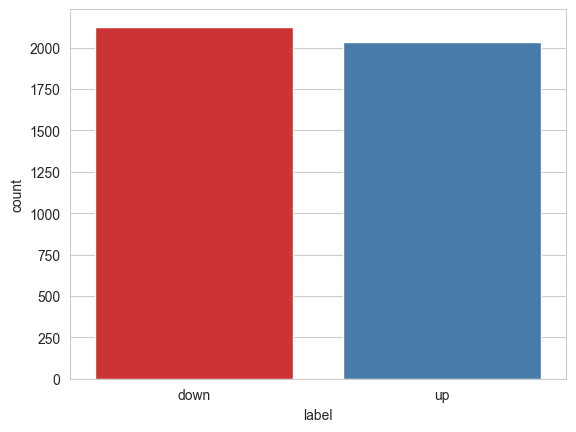

In [7]:
# Brief describe of the dataset
df = describe_dataset("./train.csv")
sns.countplot(x='label', data=df, palette="Set1") 
df.loc[df["label"] == "down", "label"] = 0
df.loc[df["label"] == "up", "label"] = 1

In [8]:
# Extract features and class
X = df.drop("label", axis=1) # features
y = df["label"].astype("int")

sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

In [9]:
# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
y_test.head(3)

3319    1
2621    0
3820    1
Name: label, dtype: int64

#### 4.2 Train Machine learning model

In [10]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])


,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,LR,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
1,SVC,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
2,KNN,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
3,DTC,"[0.998, 0.998]",0.997596,"[0.998, 0.998]","[0.998, 0.998]","[[426, 1], [1, 404]]"
4,SGDC,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
5,RF,"[0.998, 0.998]",0.997596,"[0.998, 0.998]","[0.998, 0.998]","[[426, 1], [1, 404]]"
6,NB,"[0.986, 1.0]",0.992788,"[1.0, 0.985]","[0.993, 0.993]","[[427, 0], [6, 399]]"


#### 4.3 Test set evaluation

In [11]:
test_df = describe_dataset("./test.csv")
test_df.loc[test_df["label"] == "down", "label"] = 0
test_df.loc[test_df["label"] == "up", "label"] = 1

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 853 
Number of columns: 37

Labels: 
down    430
up      423
Name: label, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: float64)


In [12]:
testset_final_results = []

for name, model in models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1])
    testset_final_results.append(( name,  (p_score), a_score, (r_score), (f1_score_result), cm ))


testset_final_results.sort(key=lambda k: k[4], reverse=True)
eval_df = pd.DataFrame(testset_final_results, columns=["Model", "Precision score", "Accuracy score", "Recall score", "F1 score", "Confusion Matrix"])
eval_df = eval_df.sort_values(by=['F1 score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision score,Accuracy score,Recall score,F1 score,Confusion Matrix
0,SGDC,0.995354,0.995311,0.995311,0.995310,"[[430, 0], [4, 419]]"
1,LR,0.994141,0.994138,0.994138,0.994138,"[[428, 2], [3, 420]]"
2,KNN,0.985207,0.984760,0.984760,0.984754,"[[430, 0], [13, 410]]"
3,SVC,0.977595,0.976553,0.976553,0.976536,"[[430, 0], [20, 403]]"
4,DTC,0.254120,0.504103,0.504103,0.337902,"[[430, 0], [423, 0]]"
5,NB,0.254120,0.504103,0.504103,0.337902,"[[430, 0], [423, 0]]"
6,RF,0.254120,0.504103,0.504103,0.337902,"[[430, 0], [423, 0]]"


#### 4.3. Dumped model using pickle

According to the evaluations, there are multiple good models at the moment, therefore, I will pick the Random Forrest model to use.

In [13]:
with open("./model/sklearn_models_jainil.pkl", "wb") as f:
    pickle.dump(models, f)

In [14]:
with open("./model/LR_model_jainil.pkl", "wb") as f:
    pickle.dump(models["LR"], f)

In [15]:
with open("./model/SGDC_model_jainil.pkl", "wb") as f:
    pickle.dump(models["SGDC"], f)

### 5. Evaluation

In [16]:
best_model = models["LR"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

(array([0.99303944, 0.99526066]),
 array([0.99534884, 0.9929078 ]),
 array([0.9941928 , 0.99408284]))

<AxesSubplot: >

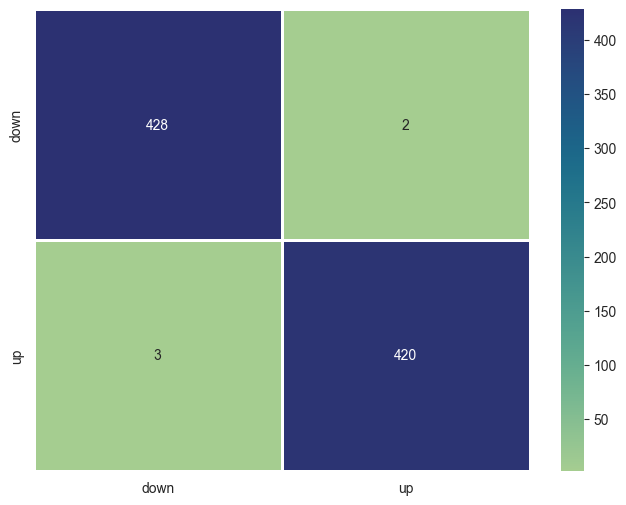

In [17]:
KNN_cm = eval_df[ eval_df["Model"] == 'LR' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(KNN_cm, index=["down", "up"], columns=["down", "up"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g', cmap="crest")

In [18]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model.predict(test_x)
    y_predict_proba = best_model.predict_proba(test_x)

    thresholds = list(np.arange(0, 1.05, 0.01))

    f1_score_results = []

    for threshold in thresholds:
        true_predictions = to_labels(y_predictions, y_predict_proba, threshold)
        f1_s = list(f1_score(test_y, true_predictions, labels=[0, 1], average=None))
        all_class_f1 = f1_score(test_y, true_predictions, labels=[0, 1], average="weighted")
        f1_s.append(all_class_f1)
        f1_score_results.append(f1_s)
    
    return thresholds, f1_score_results



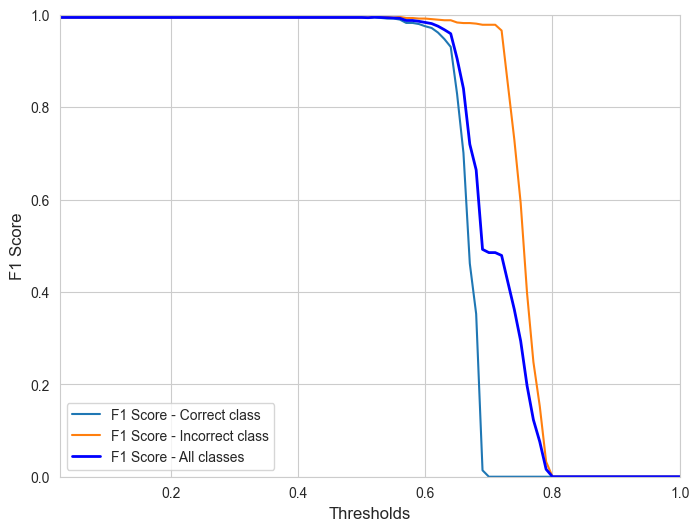

In [19]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
all_classes = [ el[2] for el in f1_scores ]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - Incorrect class")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0, 1])
plt.xlim([0.025, 1])
plt.xlabel("Thresholds", fontsize = 12)
plt.ylabel("F1 Score", fontsize = 12)
# plt.axvline(thresholds[np.argmin(abs(precision-recall))], color="k", ls = "--")
# plt.title(label = F"Threshold = {thresholds[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
plt.show()

Optimal Threshold: 0.5421684074365937


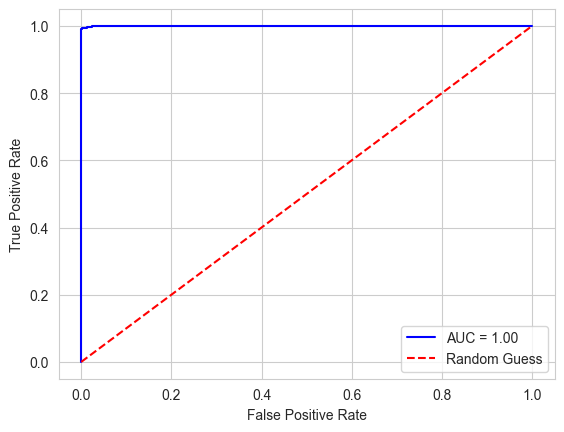

In [20]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_model.predict_proba(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# method I: plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="Random Guess")
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()